# 도배 하자 유형 분류 AI 경진대회

LINK: https://dacon.io/competitions/official/236082/overview/description

import

In [5]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

import os
import albumentations as A

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

In [ ]:
# 실행 X
#한글로 이미지 읽기 쓰기

def han_imread(ld_dir, color_mode = True) :
    img_array = np.fromfile(ld_dir, np.uint8)
    if color_mode == True :
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    else :
        img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)
    return img

def han_imwrite(sv_dir, image) :
    new_img_name = sv_dir
    extension = os.path.splitext(new_img_name)[1] # 이미지 확장자
    result, encoded_img = cv2.imencode(extension, image)
    if result:
        with open(new_img_name, mode='w+b') as f:
            encoded_img.tofile(f)

root_dir = 'train_img_add' # 이미지 파일이 있는 디렉토리
os.makedirs('Data/Training_whole/PNG', exist_ok=True)
os.makedirs('Data/Training_whole/PNG_384', exist_ok=True) 
meta_dict_list = []
i = 0
for (root, dirs, files) in tqdm(os.walk(root_dir)): # 디렉토리 내의 모든 파일 순회
    for file_name in tqdm(files):
        if ('png' in file_name) or ('jpg' in file_name) or ('bmp' in file_name) : 
            
            meta_dict = dict()
            png_img_name = os.path.basename(root) + '_' + file_name.split('.')[0] + '.png'
            meta_dict['id'] = i
            meta_dict['filename'] = png_img_name
            
            meta_dict['label'] = os.path.basename(root)
            meta_dict_list.append(meta_dict)
            
            img = han_imread(os.path.join(root, file_name))
            img_224 = cv2.resize(img, dsize = (384,384), interpolation = cv2.INTER_AREA)

            han_imwrite( os.path.join('Data/Training_whole/PNG', png_img_name), img)
            han_imwrite( os.path.join('Data/Training_whole/PNG_384', png_img_name), img_224)
            i += 1

meta_train = pd.DataFrame(meta_dict_list)
meta_train.to_csv('train.csv', index = False)

In [6]:
dir_ = Path('C:\\Users\\woo\\Desktop\\team\\image_analy\\train')
filepaths = list(dir_.glob(r'**//*.png'))

def proc_img(filepath):
    """
   		train 이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("\\")[-2]
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

In [7]:
# 
dir_test = Path('C:\\Users\\woo\\Desktop\\team\\image_analy\\test')
filepaths_test = list(dir_test.glob(r'**//*.png'))

# 
def proc_sample_img(test_filepath):
    """
   		test 이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    test_labels = [str(test_filepath[i]).split("\\")[-2]
              for i in range(len(test_filepath))]

    test_filepath = pd.Series(test_filepath, name='Filepath').astype(str)
    test_labels = pd.Series(test_labels, name='Label')

    # 경로와 라벨 concatenate
    sample_df = pd.concat([test_filepath, test_labels], axis=1)

    # index 재설정
    sample_df = sample_df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return sample_df

In [8]:
df = proc_img(filepaths)
sample_df = proc_img(filepaths_test)
len(df),len(sample_df)

(3457, 792)

In [ ]:
# label열의 한글 label값을 영어 label로 바꾸는 함수
def map_a_to_int(a_value):
    if a_value == '가구수정':
        return 'furniture' # 0
    elif a_value == '걸레받이수정':
        return 'plinth' # 1
    elif a_value == '곰팡이':
        return 'fungi' # 2
    elif a_value == '꼬임':
        return 'twist' # 3
    elif a_value == '녹오염':
        return 'greencontamination' # 4
    elif a_value == '들뜸':
        return 'excited' # 5
    elif a_value == '면불량':
        return 'face' # 6
    elif a_value == '몰딩수정':
        return 'molding' # 7
    elif a_value == '반점':
        return 'speck' # 8
    elif a_value == '석고수정':
        return 'plaster' # 9
    elif a_value == '오염':
        return 'contamination' # 10
    elif a_value == '오타공':
        return 'typ' # 11
    elif a_value == '울음':
        return 'cry' # 12
    elif a_value == '이음부불량':
        return 'joint' # 13
    elif a_value == '창틀,문틀수정':
        return 'frames' # 14
    elif a_value == '터짐':
        return 'exploded' # 15
    elif a_value == '틈새과다':
        return 'niche' # 16
    elif a_value == '피스':
        return 'piece' # 17
    elif a_value == '훼손':
        return 'damage' # 18
    else:
        return 'none'

In [5]:
# 한글 label값을 영어 label로 바꾸기
df['Label'] = df['Label'].map(map_a_to_int)

KeyError: 'Label'

In [10]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')
print("-" * 50)
print(f'Number of pictures: {sample_df.shape[0]}\n')
print(f'Number of different labels: {len(sample_df.Label.unique())}\n')
print(f'Labels: {sample_df.Label.unique()}')

Number of pictures: 3457

Number of different labels: 19

Labels: ['damage' 'molding' 'twist' 'plaster' 'plinth' 'face' 'exploded'
 'contamination' 'fungi' 'typ' 'excited' 'greencontamination' 'frames'
 'piece' 'furniture' 'cry' 'joint' 'speck' 'niche']
--------------------------------------------------
Number of pictures: 792

Number of different labels: 1

Labels: ['test']


##### 이미지 데이터 확인

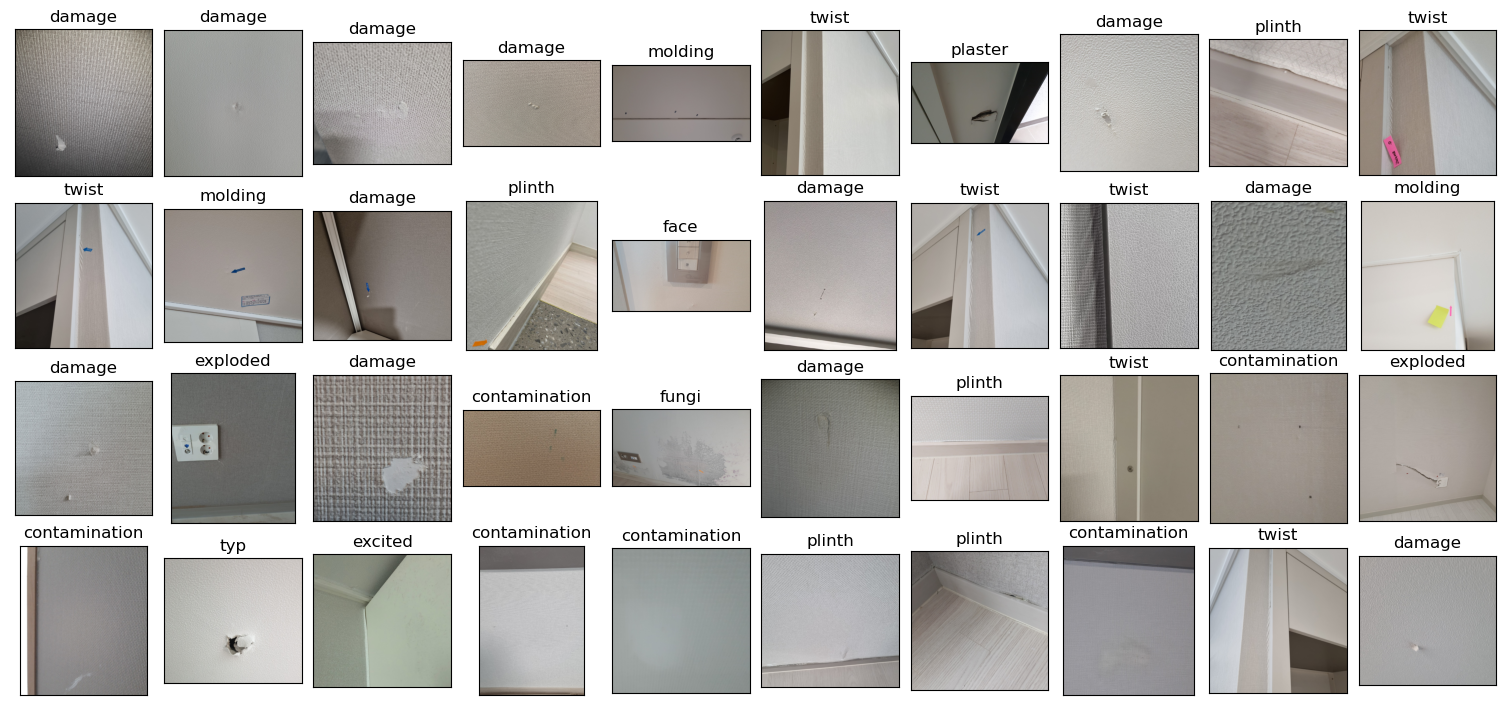

In [8]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

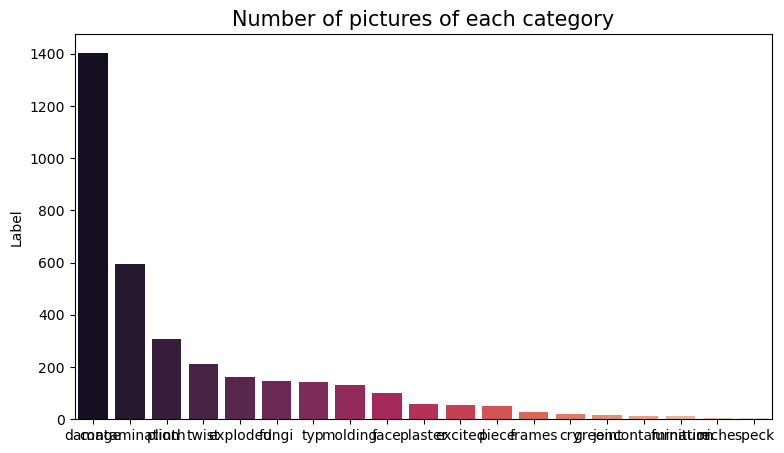

In [9]:
# Label Category 분포 확인
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

##### 이미지 데이터 Train, Test 데이터로 분류

In [11]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
#train_df,valid_df = train_test_split(df, test_size=0.1,random_state=0)
train_df = df
test_df = sample_df

train_df.shape,test_df.shape

((3457, 2), (792, 2))

### 베이스 라인 모델

모델 전처리

In [10]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('C:\\Users\\woo\\Desktop\\team\\image_analy\\train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 subset='training')
val_gen  = train_datagen.flow_from_directory('C:\\Users\\woo\\Desktop\\team\\image_analy\\train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 subset='validation')

Found 2772 images belonging to 19 classes.
Found 685 images belonging to 19 classes.


딥러닝 CNN모델로 베이스라인 모델링

In [11]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
num_classes = 19
cnn.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

모델 성능 확인(accuracy)

In [12]:
# accuracy: 0.8229 / val_accuracy: 0.4482
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
87/87 [==============================] - 108s 1s/step - loss: 2.2832 - accuracy: 0.3882 - val_loss: 2.0402 - val_accuracy: 0.4102
Epoch 2/10
87/87 [==============================] - 79s 909ms/step - loss: 1.9935 - accuracy: 0.4022 - val_loss: 1.9089 - val_accuracy: 0.4146
Epoch 3/10
87/87 [==============================] - 80s 926ms/step - loss: 1.8108 - accuracy: 0.4437 - val_loss: 1.9126 - val_accuracy: 0.4219
Epoch 4/10
87/87 [==============================] - 81s 926ms/step - loss: 1.5983 - accuracy: 0.5047 - val_loss: 1.8429 - val_accuracy: 0.4350
Epoch 5/10
87/87 [==============================] - 81s 928ms/step - loss: 1.3508 - accuracy: 0.5675 - val_loss: 1.9810 - val_accuracy: 0.4438
Epoch 6/10
87/87 [==============================] - 81s 929ms/step - loss: 1.1114 - accuracy: 0.6457 - val_loss: 2.1199 - val_accuracy: 0.4613
Epoch 7/10
87/87 [==============================] - 80s 926ms/step - loss: 0.9261 - accuracy: 0.7027 - val_loss: 2.2337 - val_accuracy: 0.4657
E

### 데이터 증강(Data Augmentation)으로 이미지 로드

In [4]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

##### 전이학습을 사용해서 모델 성능 높이기

In [14]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
}

In [15]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

Found 3112 validated image filenames belonging to 19 classes.
Found 345 validated image filenames belonging to 19 classes.
Found 792 validated image filenames belonging to 1 classes.




In [3]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(19, activation='softmax')(x)
    # 라벨 개수가 19개이기 때문에 Dencs도 19로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [17]:
# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

DenseNet121          trained in 109.77 sec
MobileNetV2          trained in 55.74 sec
DenseNet201          trained in 165.01 sec
EfficientNetB0       trained in 68.8 sec
EfficientNetB1       trained in 81.3 sec
InceptionV3          trained in 94.06 sec
MobileNetV3Large     trained in 57.41 sec
ResNet152V2          trained in 327.58 sec
ResNet50             trained in 135.46 sec
ResNet50V2           trained in 119.67 sec


Test 데이터로 성능 확인

In [18]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test, pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

25/25 [==============================] - 30s 1s/step
**DenseNet121 has a 0.00% accuracy on the test set**
25/25 [==============================] - 13s 484ms/step
**MobileNetV2 has a 0.00% accuracy on the test set**
25/25 [==============================] - 39s 1s/step
**DenseNet201 has a 0.00% accuracy on the test set**
25/25 [==============================] - 16s 545ms/step
**EfficientNetB0 has a 0.00% accuracy on the test set**
25/25 [==============================] - 18s 607ms/step
**EfficientNetB1 has a 0.00% accuracy on the test set**
25/25 [==============================] - 22s 803ms/step
**InceptionV3 has a 0.00% accuracy on the test set**
25/25 [==============================] - 13s 485ms/step
**MobileNetV3Large has a 0.00% accuracy on the test set**
25/25 [==============================] - 75s 3s/step
**ResNet152V2 has a 0.00% accuracy on the test set**
25/25 [==============================] - 32s 1s/step
**ResNet50 has a 0.00% accuracy on the test set**
25/25 [================

In [19]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])

In [20]:
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet121,0.6522,0.0,109.77
1,MobileNetV2,0.6493,0.0,55.74
2,DenseNet201,0.6493,0.0,165.01
3,EfficientNetB0,0.4145,0.0,68.80
4,EfficientNetB1,0.4145,0.0,81.30
5,InceptionV3,0.6000,0.0,94.06
6,MobileNetV3Large,0.4406,0.0,57.41
7,ResNet152V2,0.6290,0.0,327.58
8,ResNet50,0.4464,0.0,135.46
9,ResNet50V2,0.6986,0.0,119.67


학습한 모델에 test셋을 통해서 전이모델별 성능을 확인

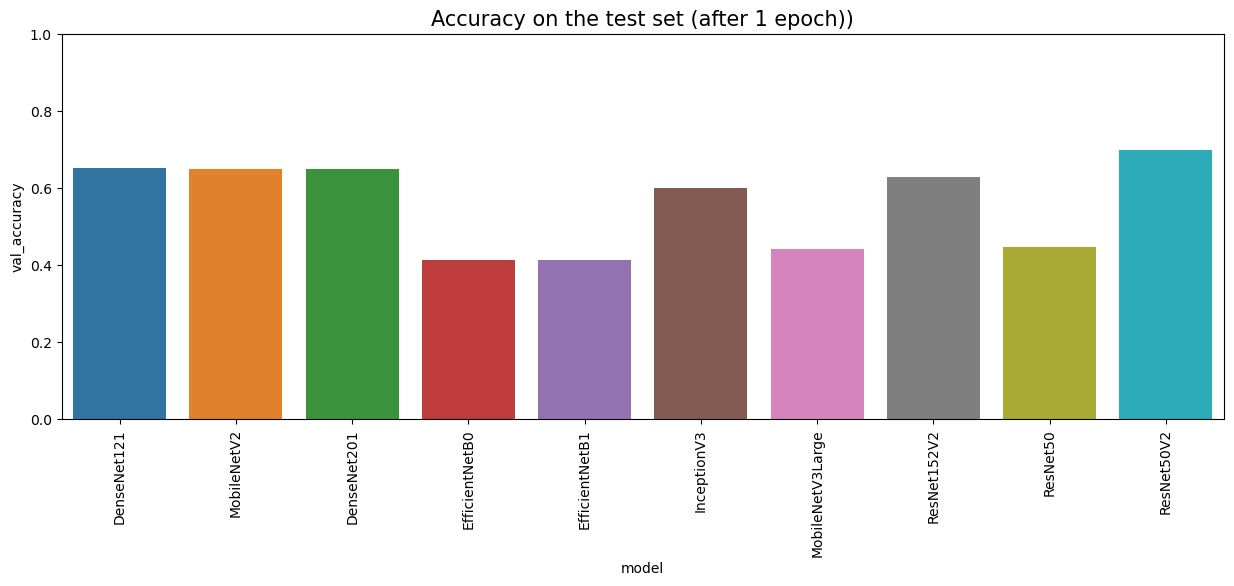

In [21]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

정확도를 시각화

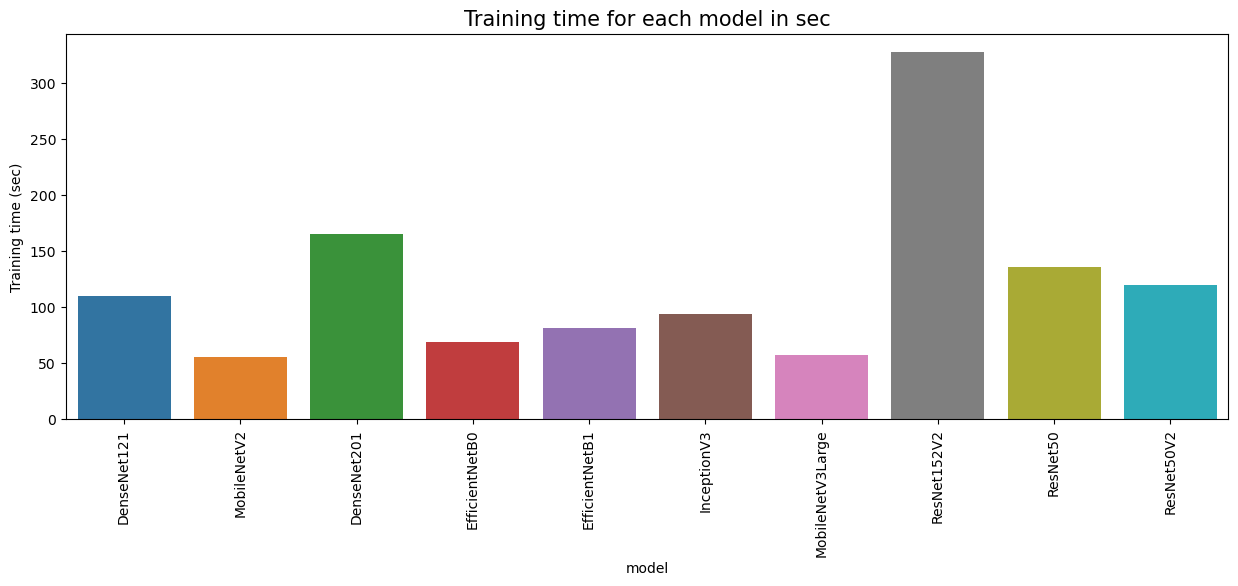

In [22]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

### 모델 성능 확인

In [ ]:
# label열의 영어label 값을 한글 label로 바꾸는 함수
def map_a_to_label(a_value):
    if a_value == 'furniture':
        return '가구수정' # 0
    elif a_value == 'plinth':
        return '걸레받이수정' # 1
    elif a_value == 'fungi':
        return '곰팡이' # 2
    elif a_value == 'twist':
        return '꼬임' # 3
    elif a_value == 'greencontamination':
        return '녹오염' # 4
    elif a_value == 'excited':
        return '들뜸' # 5
    elif a_value == 'face':
        return '면불량' # 6
    elif a_value == 'molding':
        return '몰딩수정' # 7
    elif a_value == 'speck':
        return '반점' # 8
    elif a_value == 'plaster':
        return '석고수정' # 9
    elif a_value == 'contamination':
        return '오염' # 10
    elif a_value == 'typ':
        return '오타공' # 11
    elif a_value == 'cry':
        return '울음' # 12
    elif a_value == 'joint':
        return '이음부불량' # 13
    elif a_value == 'frames':
        return '창틀,문틀수정' # 14
    elif a_value == 'exploded':
        return '터짐' # 15
    elif a_value == 'niche':
        return '틈새과다' # 16
    elif a_value == 'piece':
        return '피스' # 17
    elif a_value == 'damage':
        return '훼손' # 18
    else:
        return 'none'

##### ResNet50V2

In [23]:
# ResNet152V2
train_df = df
test_df = sample_df
#train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)

train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=5)

Found 3112 validated image filenames belonging to 19 classes.
Found 345 validated image filenames belonging to 19 classes.
Found 792 validated image filenames belonging to 1 classes.
Epoch 1/5
98/98 [==============================] - 127s 1s/step - loss: 1.3578 - accuracy: 0.5688 - val_loss: 0.9628 - val_accuracy: 0.6696
Epoch 2/5
98/98 [==============================] - 127s 1s/step - loss: 0.8290 - accuracy: 0.7220 - val_loss: 0.8867 - val_accuracy: 0.7304
Epoch 3/5
98/98 [==============================] - 133s 1s/step - loss: 0.5647 - accuracy: 0.8094 - val_loss: 0.8579 - val_accuracy: 0.7246
Epoch 4/5
98/98 [==============================] - 131s 1s/step - loss: 0.3893 - accuracy: 0.8737 - val_loss: 0.9035 - val_accuracy: 0.7536
Epoch 5/5
98/98 [==============================] - 122s 1s/step - loss: 0.2625 - accuracy: 0.9148 - val_loss: 0.9347 - val_accuracy: 0.7246


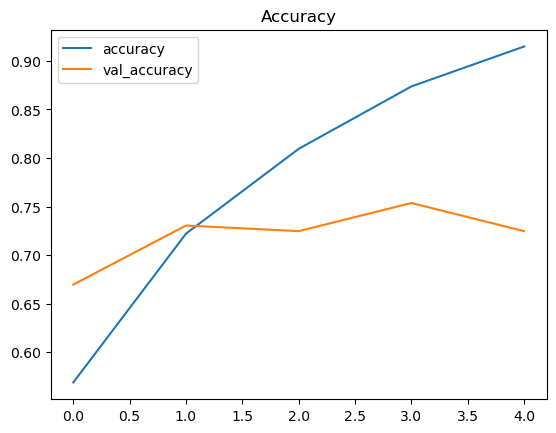

In [24]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

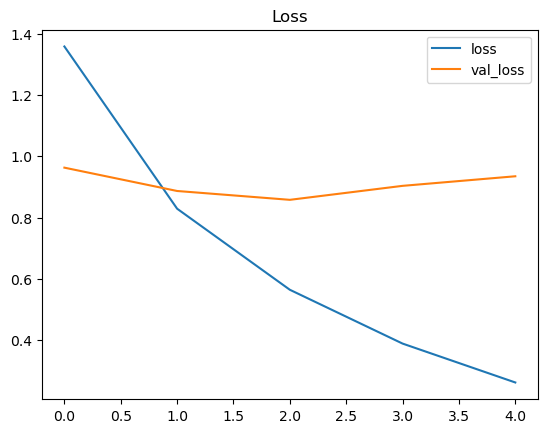

In [25]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [26]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test, pred)

25/25 [==============================] - 29s 1s/step


pred 1

In [27]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손


In [28]:
submit['label'] = pred

In [30]:
# 영어label 값을 한글 label로 바꾸기
submit['label'] = submit['label'].map(map_a_to_label)
submit.head()

In [32]:
# 0.2...
submit.to_csv('./ResNet50V2_submit.csv', index=False)

##### MobileNetV2

In [33]:
# MobileNetV2
train_df = df
test_df = sample_df
# train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model_2 = get_model(tf.keras.applications.MobileNetV2)
history_2 = model_2.fit(train_images,validation_data=val_images,epochs=7)

Found 3112 validated image filenames belonging to 19 classes.
Found 345 validated image filenames belonging to 19 classes.
Found 792 validated image filenames belonging to 1 classes.
Epoch 1/7
98/98 [==============================] - 57s 550ms/step - loss: 1.4526 - accuracy: 0.5411 - val_loss: 1.0590 - val_accuracy: 0.6580
Epoch 2/7
98/98 [==============================] - 54s 555ms/step - loss: 0.9604 - accuracy: 0.6812 - val_loss: 0.9267 - val_accuracy: 0.6841
Epoch 3/7
98/98 [==============================] - 54s 553ms/step - loss: 0.7573 - accuracy: 0.7410 - val_loss: 0.8270 - val_accuracy: 0.7275
Epoch 4/7
98/98 [==============================] - 54s 552ms/step - loss: 0.6117 - accuracy: 0.7876 - val_loss: 0.9291 - val_accuracy: 0.6841
Epoch 5/7
98/98 [==============================] - 54s 546ms/step - loss: 0.4898 - accuracy: 0.8335 - val_loss: 0.8009 - val_accuracy: 0.7362
Epoch 6/7
98/98 [==============================] - 53s 545ms/step - loss: 0.4077 - accuracy: 0.8618 - val_l

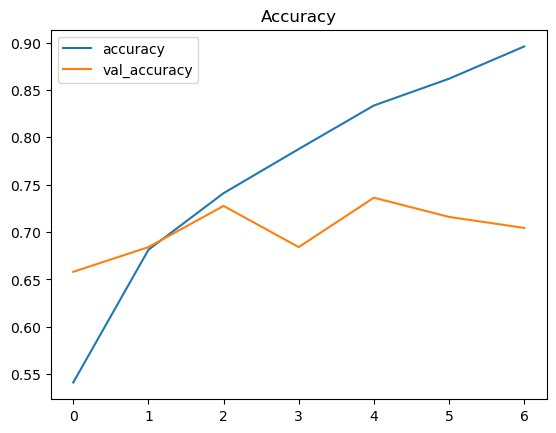

In [34]:
pd.DataFrame(history_2.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

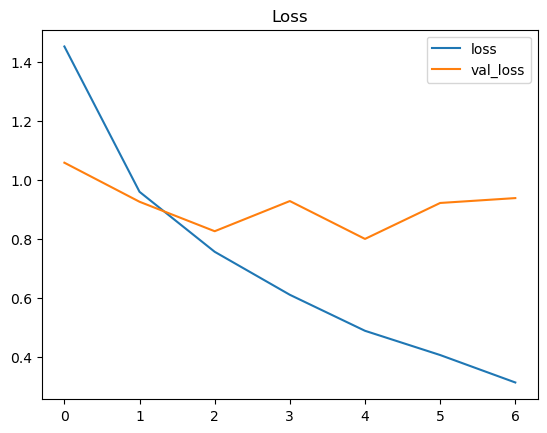

In [35]:
pd.DataFrame(history_2.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [36]:
# Predict the label of the test_images
pred_2 = model_2.predict(test_images)
pred_2 = np.argmax(pred_2,axis=1)

# Map the label
labels_2 = (train_images.class_indices)
labels_2 = dict((v,k) for k,v in labels_2.items())
pred_2 = [labels_2[k] for k in pred_2]
    
y_test_2 = list(test_df.Label)
acc_2 = accuracy_score(y_test_2,pred_2)

25/25 [==============================] - 13s 513ms/step


pred 2

In [37]:
submit_2 = pd.read_csv('sample_submission.csv')
submit_2.head()

,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손


In [38]:
submit_2['label'] = pred_2

# 영어label 값을 한글 label로 바꾸기
submit_2['label'] = submit_2['label'].map(map_a_to_label)
submit_2.head()

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,오염
3,TEST_003,훼손
4,TEST_004,훼손


In [39]:
# 0.2...
submit_2.to_csv('./MobileNetV2_var2_submit.csv', index=False)

##### DenseNet121

In [12]:
# DenseNet121
train_df = df
test_df = sample_df
# train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model_3 = get_model(tf.keras.applications.DenseNet121)
history_3 = model_3.fit(train_images,validation_data=val_images,epochs=15)

Found 3112 validated image filenames belonging to 19 classes.
Found 345 validated image filenames belonging to 19 classes.
Found 792 validated image filenames belonging to 1 classes.
Epoch 1/15
98/98 [==============================] - 177s 2s/step - loss: 1.4949 - accuracy: 0.5325 - val_loss: 1.1274 - val_accuracy: 0.6290
Epoch 2/15
98/98 [==============================] - 149s 2s/step - loss: 1.0161 - accuracy: 0.6745 - val_loss: 1.0050 - val_accuracy: 0.6667
Epoch 3/15
98/98 [==============================] - 140s 1s/step - loss: 0.8567 - accuracy: 0.7175 - val_loss: 0.9068 - val_accuracy: 0.7246
Epoch 4/15
98/98 [==============================] - 146s 1s/step - loss: 0.7373 - accuracy: 0.7497 - val_loss: 0.8319 - val_accuracy: 0.7188
Epoch 5/15
98/98 [==============================] - 149s 2s/step - loss: 0.6552 - accuracy: 0.7738 - val_loss: 0.8322 - val_accuracy: 0.7101
Epoch 6/15
98/98 [==============================] - 151s 2s/step - loss: 0.5763 - accuracy: 0.7995 - val_loss: 0

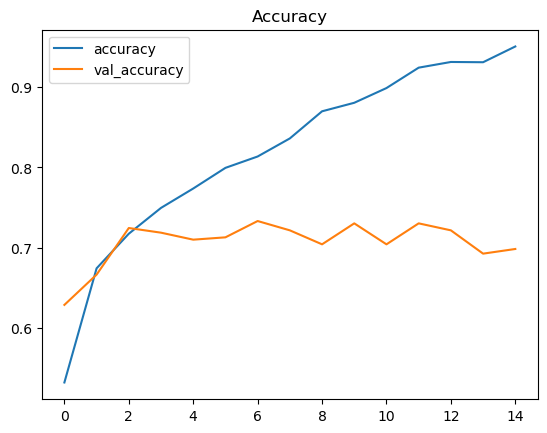

In [13]:
pd.DataFrame(history_3.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

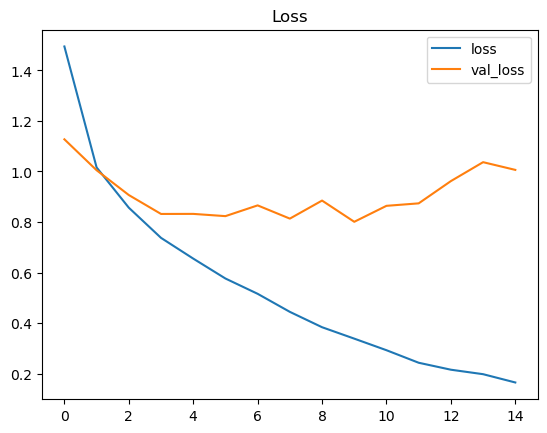

In [14]:
pd.DataFrame(history_3.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [15]:
# Predict the label of the test_images
pred_3 = model_3.predict(test_images)
pred_3 = np.argmax(pred_3,axis=1)

# Map the label
labels_3 = (train_images.class_indices)
labels_3 = dict((v,k) for k,v in labels_3.items())
pred_3 = [labels_3[k] for k in pred_3]

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test_3 = list(test_df.Label)
acc_3 = accuracy_score(y_test_3, pred_3)

25/25 [==============================] - 39s 1s/step


pred 3

In [21]:
submit_3 = pd.read_csv('sample_submission.csv')
submit_3.head()

,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손


In [22]:
submit_3['label'] = pred_3

# 영어label 값을 한글 label로 바꾸기
submit_3['label'] = submit_3['label'].map(map_a_to_label)
submit_3.head()

,id,label
0,TEST_000,훼손
1,TEST_001,훼손
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손


In [23]:
# epoch = 7 = 0.23.. 
# epoch = 15
submit_3.to_csv('./DenseNet121_submit_epoch15.csv', index=False)

### etc

In [ ]:
# 실행X
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input


In [ ]:
# 실행X
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'airplane': 0,
                    'car': 1,
                    'cat': 2,
                    'dog': 3,
                    'flower': 4,
                    'fruit': 5,
                    'motorbike': 6,
                    'person': 7}
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

In [ ]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"Predicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()